In [1]:
# Imports

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

# Keras
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Adadelta
from keras.regularizers import L1L2, L2

# SMOTE
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTENC

In [2]:
# Use KNN imputation to predict missing values
# Except for categorical columns (columns with less than 10 values), which are replaced by mode
def fill_empty_2(df):
    num_nulls = df.isnull().sum()
    has_nulls = num_nulls[num_nulls > 0].to_frame()
    num_values = df[has_nulls.index].apply(lambda x: len(x.value_counts()))
    categorical_cols = num_values[num_values<=10].to_frame().index
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode())
    imputer = KNNImputer()
    return pd.DataFrame(imputer.fit_transform(df)), categorical_cols

In [3]:
# Load in the data
df = pd.read_csv('./train_data.csv')

print(df.target.value_counts())

# Make boolean columns into integer columns
df.replace({False: 0, True: 1}, inplace=True)

# Split the data into target labels y and features X
num_train = df.select_dtypes(include=np.number)
train_y = df.target
train_X = df.drop(['target'], axis = 1)

# Fill empty values in the train data 
train_X_columns = train_X.columns
train_X, categorical_cols = fill_empty_2(train_X) #train_X.fillna(train_X.mean())

# Custom z-score method because scipy caused NaN problems in some columns
def z_score(arr):
    mean = np.mean(arr, axis = 0)
    std = np.std(arr, axis = 0)
    std[std == 0] = 1
    return (arr-mean)/std

# Keep track of which columns might be categorical (calculated in fill_empty_2)
col_idx = []
for col in categorical_cols:
    col_idx.append(train_X_columns.get_loc(col))

# Normalize the data using z-score standardization
train_X = z_score(train_X.to_numpy(dtype = np.float64)) #.to_numpy(dtype = np.float64)
train_df = pd.DataFrame(train_X)

2    1032
1     314
0     247
Name: target, dtype: int64


In [4]:
train_X = pd.DataFrame(train_X)

# Oversample a little bit for the target values that are underrepresented (e.g. target=0, target=1)
smote_nc = SMOTENC(categorical_features=col_idx, random_state=0, sampling_strategy = {1:500, 0:400}, k_neighbors = 5) # categorical_features=col_idx,
train_X, train_y = smote_nc.fit_resample(train_X, train_y)

In [5]:
# Turn y into categorical variable
y = to_categorical(train_y, num_classes = 3)
input_dim = train_X.shape[1]

In [6]:
# Apply randomforestclassifier to find feature importances (based on entropy)
# Then feature select on this feature importance
train_X = pd.DataFrame(train_X)
feature_names = [f"feature {i}" for i in range(train_X.shape[1])]
forest = RandomForestClassifier(random_state=0, criterion = "entropy")
col_importances = forest.fit(train_X, train_y).feature_importances_

columns = train_X.columns.to_frame()
columns['importance'] = col_importances
columns.sort_values(by = 'importance', ascending = False)
important_cols_names = columns[columns.importance>columns.importance.median()]
important_cols = important_cols_names.index

train_X = train_X[important_cols]

In [7]:
def create_model(input_dim, dropout = 0.5, lr = 1e-2):
    # Initialize HE initializers and L2 regularizer
    initializer = keras.initializers.HeNormal()
    regularizer = L2(0.01)
    # create model
    model = Sequential()
    
    # Use 3 dense layers with relu activation, with batchnormalization and dropout inbetween
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_initializer = initializer))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_initializer = initializer, kernel_regularizer = regularizer)) 
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_initializer = initializer, kernel_regularizer = regularizer))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    # Last layer is softmax
    model.add(Dense(3, activation='softmax'))
    
    # SGD optimizer
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=lr, momentum = 0.9, nesterov=True), metrics=['accuracy'])
    return model

def avg(arr):
    return sum(arr)/len(arr)


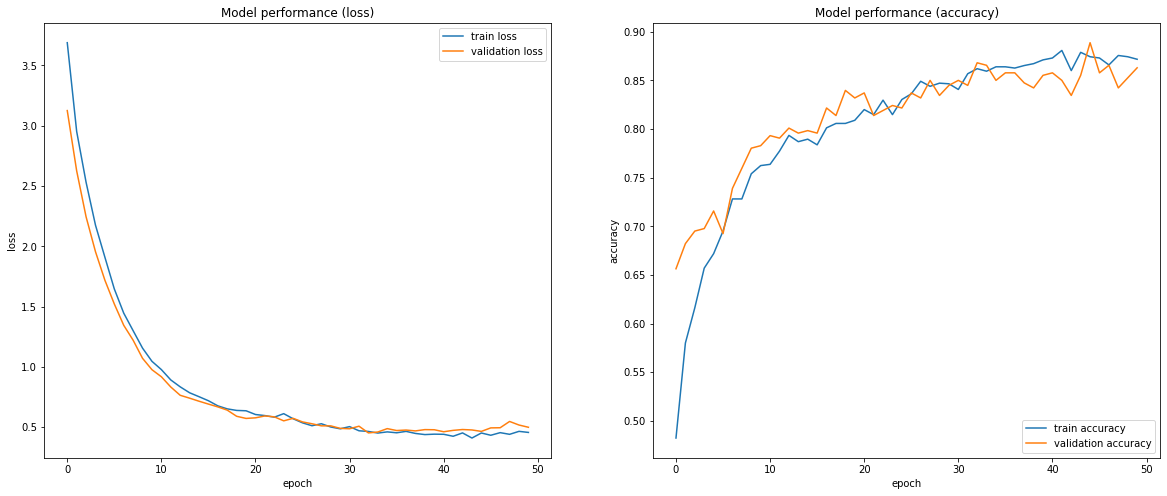

Train accuracy:			0.87	Train loss: 0.46
Validation accuracy:		0.86	Validation loss: 0.50
Best validation accuracy:	0.89 (epoch 44)
Best validation loss:		0.45 (epoch 32)


0.8888888955116272

In [8]:
from sklearn.model_selection import StratifiedKFold
def train_network(model, X_train, y_train, X_val, y_val, best_val_acc = 0, plot = True,
                  n_epochs = 10, batch_size = 32, verbose = 1, save = False, path = 'best_model'):

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = best_val_acc
    best_val_loss = 1
    best_acc_epoch = 0
    best_loss_epoch = 0

    # Loop over epochs
    for epoch in range(n_epochs):

        # Train model
        results = model.fit(X_train, y_train, batch_size = batch_size, verbose = verbose)

        # Get training loss and accuracy and append to lists
        train_losses.append(results.history['loss'])
        train_accs.append(results.history['accuracy'])

        # Get performance (i.e. loss and accuracy) on validation set
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose = verbose)

        # Append to lists
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Keep track of which epoch had the best validation accuracy and store the corresponding model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_acc_epoch = epoch
            if save:
                model.save(path)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_loss_epoch = epoch

    # Visualise the performance of the model for the epochs
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        ax[0].plot(train_losses) 
        ax[1].plot(train_accs)
        ax[0].plot(val_losses)
        ax[1].plot(val_accs)

        # Text and legend for the plot
        ax[0].legend(['train loss', 'validation loss'],
                  loc='upper right', bbox_to_anchor=(1,1))
        ax[1].legend(['train accuracy', 'validation accuracy'],
                  loc='lower right', bbox_to_anchor=(1,0))
        ax[0].set_xlabel('epoch')
        ax[0].set_ylabel('loss')
        ax[0].set_title('Model performance (loss)')
        
        ax[1].set_xlabel('epoch')
        ax[1].set_ylabel('accuracy')
        ax[1].set_title('Model performance (accuracy)')

        plt.show()

    # Print the performance values (accuracies, loss) for train, validation
    print('Train accuracy:\t\t\t{:.2f}\tTrain loss: {:.2f}'.format(train_accs[-1][0], train_losses[-1][0]))
    print('Validation accuracy:\t\t{:.2f}\tValidation loss: {:.2f}'.format(val_accs[-1], val_losses[-1]))
    print('Best validation accuracy:\t{:.2f} (epoch {:})'.format(best_val_acc, best_acc_epoch))
    print('Best validation loss:\t\t{:.2f} (epoch {:})'.format(best_val_loss, best_loss_epoch))
    
    return best_val_acc
        


# Make a 80/20 train-test split and create the model
X_train, X_val, y_train, y_val = train_test_split(train_X, y, stratify = y, test_size=0.2, shuffle = True)
model = create_model(train_X.shape[1])

# Train the model
save = False
train_network(model, X_train, y_train, X_val, y_val, n_epochs = 50, batch_size = 32, verbose = 0, save = save)

In [9]:
# Create prediction dataset
from tensorflow import keras
if save:
    model = keras.models.load_model('best_model')
naming_cols = ['opportunity_id', 'current_date_day', 'current_date_month', 'current_date_year']
test_df = pd.read_csv('./data2tal_testupload.csv')
index_names = pd.read_csv('./check_upload_kaggle.csv')

# Reset test set columns to numerical 
test_df.columns = list(range(test_df.shape[1]))
# Filter test set to importand columns (which are numerical)
test_df = test_df[important_cols]

train_X_df = pd.DataFrame(train_X)

# Reset column names of train and test set so they can be concatenated 
train_X_df.columns = list(range(train_X_df.shape[1]))
test_df.columns = list(range(train_X_df.shape[1]))
fused = pd.concat([test_df, train_X_df])

# Impute missing values in the test set
# Train and test are concatenated so there is some reference for fully empty columns for how to impute them
# Then, get back the first 188 rows (= test set)
imputer = KNNImputer()
filled_fused = imputer.fit_transform(fused)[:188]
filled_fused = z_score(filled_fused)

# Predict on the imputed test set
pred = model.predict(filled_fused)
pred_target = np.argmax(pred, axis = 1)
print(pred_target)

# Create dataframe, using index column from 'check_upload_kaggle.csv' and predictions (see above) as target column
df_pred = pd.DataFrame([])
df_pred['index'] = index_names['index']
df_pred['target'] = pred_target

# Save as a .csv
df_pred.to_csv('./prediction.csv', index = False)

[2 2 2 2 2 2 0 2 1 2 2 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 2 1 2 0 0 0 0 0 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 0 0 1 0 0 0
 1 0 0]
